<a href="https://colab.research.google.com/github/WoobeenJeong/Bioinfomatics_Practice_RNAseq/blob/main/Project_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [4]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [ ]:
!md5sum /content/drive/MyDrive/binfo1-work/*

**4) Background setting**

In [5]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

먼저 GTF파일은 genecode로부터 M32버전이 (2023.02월에) 나왔으며  
M32(GRCm39) Refseq 자료 중 chr9에 대해 확인 할 것  
NCBI RefSeq에서도 Mus musculus strain C57BL/6J chromosome 9, GRCm39 존재

1) C=Shannon’s entrophy를 CRES: Crosslinking-induced reverse transcription error score로 가져감  
2) 이때, insertion은 무시 substitution과 deletion고려  
3) FDR은 permutation으로 구함   
4) Read는 rRNA,tRNA,adapte제외하고 GSNAP의 Refseq에 align  
5) 이를 바탕으로, 먼저 CRES(0.8) 상 low depth positio이 130 reads 이하  
6) LOESS smoothing (regression) a=0.5사용 medium depth positon 250 read이하  
7) FDR(0.001)상 high depth position >250 read 사용  

In [6]:
!gzip -d gencode.vM32.annotation.gtf.gz

gzip: gencode.vM32.annotation.gtf.gz: No such file or directory


In [ ]:
!grep 'chr9' gencode.vM32.annotation.gtf > gencode.vM32.chr9.gtf

In [ ]:
!head gencode.vM32.chr9.gtf

In [ ]:
!awk -F'\t' '{if ($3 == "gene") print $4}' gencode.vM32.chr9.gtf | sort -n | head -n 1
!awk -F'\t' '{if ($3 == "gene") print $5}' gencode.vM32.chr9.gtf | sort -n | tail -n 1

3038669
124252776


In [11]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:3038669-124252776
!samtools view CLIP-let7g.bam | wc -l

1696165


In [27]:
!samtools index CLIP-let7g.bam

In [29]:
!samtools view -F 16 CLIP-let7g.bam | wc -l

905001


In [34]:
!samtools view -b -F 0x10 -o forward-CLIP-let7g.bam CLIP-let7g.bam

In [35]:
!samtools view -f 16 forward-CLIP-let7g.bam  | wc -l

0


In [37]:
!samtools view -F 16 forward-CLIP-let7g.bam  | wc -l

905001


In [38]:
!samtools mpileup forward-CLIP-let7g.bam 2>/dev/null > forward-CLIP-let7g.pileup
!wc -l forward-CLIP-let7g.pileup

19118539 forward-CLIP-let7g.pileup


In [9]:
!awk '$2 >= 3038669 && $2 <= 124252714 { print $0; }' CLIP-let7g.pileup > CLIP-let7g-gene.pileup
!tail -n 2 CLIP-let7g-gene.pileup

^C
chr9	72975808	N	1	<	8
chr9

In [ ]:
pileup = pd.read_csv('CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,_ref,count,basereads,quals
47303558,chr9,124252283,N,1,g,H
47303559,chr9,124252284,N,1,g,G
47303560,chr9,124252285,N,1,a,F
47303561,chr9,124252286,N,1,c,E
47303562,chr9,124252287,N,1,c$,D


In [ ]:
count의 개수가 최대 / 최소 얼마이고 볼 만한 수준인지 확인

In [ ]:
len(np.unique(pileup['count']))

2443

In [ ]:
pileup['count'].describe()

count    4.730356e+07
mean     1.007026e+01
std      3.933483e+01
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      7.983000e+03
Name: count, dtype: float64

In [ ]:
np.max(pileup['count'])

7983

위를 보면 알수 있듯이 한 75%까지는 10개정도만 count되어 있는데, 무려 7983 read가 count되는 경우도 있음.  
이경우는 좀 궁금하긴 하다만, 너무 크기 때문에, threshold <=130 reads로 두고 진행   
(Shannon에서 depth 50으로 했으므로)

In [ ]:
filter130pileup = pileup[pileup['count'] > 50]

In [ ]:
len(np.unique(filter130pileup['count']))

2392

In [ ]:
len(np.unique(filter130pileup['pos']))

1044372

In [ ]:
filter130pileup['count'].describe()

count    1.044372e+06
mean     1.360591e+02
std      2.265502e+02
min      5.100000e+01
25%      5.900000e+01
50%      7.500000e+01
75%      1.230000e+02
max      7.983000e+03
Name: count, dtype: float64

In [ ]:
max(filter130pileup['pos']),max(filter130pileup['pos'])-min(filter130pileup['pos'])

(123519204, 120260609)

match와 substitution, deletion을 사용할 것이므로, 나머지에 해당하는 tag들은 제거.  
**여기서 Deletion은 포함하는 경우를 고려하는 것을 고민할 것**

In [ ]:
toremove = re.compile(r'[<>$*#+-]|\^.')
filter130pileup.loc[:, 'matches'] = filter130pileup['basereads'].apply(lambda x: toremove.sub('', x))

<ipython-input-17-150fc2d60f7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter130pileup.loc[:, 'matches'] = filter130pileup['basereads'].apply(lambda x: toremove.sub('', x))


In [ ]:
filter130pileup[['chrom', 'pos', 'matches']].head()

,chrom,pos,matches
835,chr9,3258595,gagggggggggagagggaggggggggagaggggggggggggggggg...
836,chr9,3258596,tttttttttttttttttttttttttttttttttttttttttttttt...
837,chr9,3258597,tttttttttatttttttttttttttttttttttttttttttttttt...
838,chr9,3258598,cccccccccccccccccccccccccccccccccccccccccccccc...
839,chr9,3258599,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...


Deletion상관 없이 Insertion하고 Hard-clipped read만 제외

In [ ]:
filter130pileup['base_count'] = filter130pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))
filter130pileup.head()

<ipython-input-19-80f731dc1106>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter130pileup['base_count'] = filter130pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))


,chrom,pos,_ref,count,basereads,quals,matches,base_count
835,chr9,3258595,N,80,gagggggggggagagggaggggggggagaggggg^Ig^$g^Gg^Gg...,GEHD4@I@DGHIIBIGIIII>GHHII8G=2>GGGII:GBI=EIGIF...,gagggggggggagagggaggggggggagaggggggggggggggggg...,80
836,chr9,3258596,N,116,tttttttttttttttttttttttttttttttttttttttttttttt...,HEIGD=IGGDIIIBIIIIII9GEHIHEGG?GG@GII@GGH3DIGII...,tttttttttttttttttttttttttttttttttttttttttttttt...,116
837,chr9,3258597,N,120,tttttttttatttttttttttttttttttttttttttttttttttt...,FEIDD8IBGDIII<IGIIII<GHHIIGGG;EEGGIH:EGIAGEGII...,tttttttttatttttttttttttttttttttttttttttttttttt...,120
838,chr9,3258598,N,119,cccccccccccccccccccccccccccccccccccccccccccccc...,HHIED2IE3EIIH?FIIIGI<GHHIHGGG?>BB>GI7FEH?GCGFI...,cccccccccccccccccccccccccccccccccccccccccccccc...,119
839,chr9,3258599,N,131,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,HGI@=;IEHBIIIBIIIIII<FGHIH<GG=HGDGHI6E@I?EEFIH...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,131


In [ ]:
np.unique(filter130pileup['base_count'])

array([    0,     1,     2, ...,  9308, 10219, 10269])

Colab RAM사용 제한 상, 데이터가 날라가는 것을 방지하기 위해 일단 결과 csv 저장

In [ ]:
filter130pileup.to_csv('filter130pileup.csv', index=True)

RAM 사용량 상, 작업을 다른 주피터 노트북에 작성

In [ ]:
filter130pileup.head()

,chrom,pos,_ref,count,basereads,quals,matches,base_count
835,chr9,3258595,N,80,gagggggggggagagggaggggggggagaggggg^Ig^$g^Gg^Gg...,GEHD4@I@DGHIIBIGIIII>GHHII8G=2>GGGII:GBI=EIGIF...,gagggggggggagagggaggggggggagaggggggggggggggggg...,80
836,chr9,3258596,N,116,tttttttttttttttttttttttttttttttttttttttttttttt...,HEIGD=IGGDIIIBIIIIII9GEHIHEGG?GG@GII@GGH3DIGII...,tttttttttttttttttttttttttttttttttttttttttttttt...,116
837,chr9,3258597,N,120,tttttttttatttttttttttttttttttttttttttttttttttt...,FEIDD8IBGDIII<IGIIII<GHHIIGGG;EEGGIH:EGIAGEGII...,tttttttttatttttttttttttttttttttttttttttttttttt...,120
838,chr9,3258598,N,119,cccccccccccccccccccccccccccccccccccccccccccccc...,HHIED2IE3EIIH?FIIIGI<GHHIHGGG?>BB>GI7FEH?GCGFI...,cccccccccccccccccccccccccccccccccccccccccccccc...,119
839,chr9,3258599,N,131,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,HGI@=;IEHBIIIBIIIIII<FGHIH<GG=HGDGHI6E@I?EEFIH...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,131


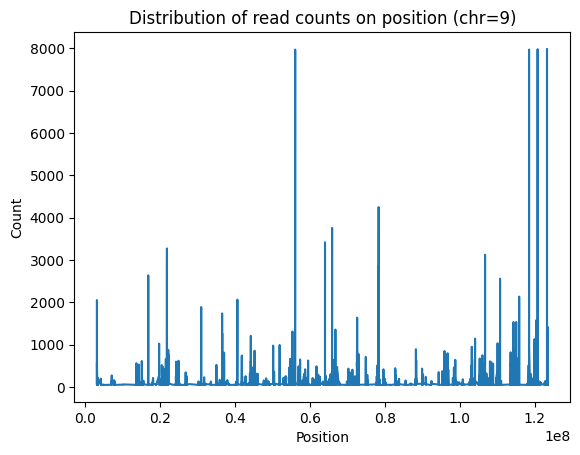

In [ ]:
x = filter130pileup['pos']
y = filter130pileup['count']

plt.plot(x, y)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Distribution of read counts on position (chr=9)')
plt.show()

In [ ]:
np.unique(filter130pileup['base_count'])

array([    0,     1,     2, ...,  9308, 10219, 10269])

In [ ]:
pup = filter130pileup[filter130pileup['base_count']>250]

In [ ]:
pup['nonzero'] = pup['base_count']/pup['basereads'].apply(len)
pup.head()

<ipython-input-53-ef3998149eec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['nonzero'] = pup['base_count']/pup['basereads'].apply(len)


,chrom,pos,_ref,count,basereads,quals,matches,base_count,nonzero
945,chr9,3258846,N,364,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,?DGDDIAHD>?IHCAE?FBHED?HFIFII:@@<7.>3<>;>EGHH@...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,364,0.376033
946,chr9,3258847,N,590,cccccccccccccccccccccccccccccccccccccccccccccc...,ADGGGHEHIDDIGC?EAIDIIG@IIIEII@BC=?6B=AACBGIHH;...,cccccccccccccccccccccccccccccccccccccccccccccc...,590,0.569498
947,chr9,3258848,N,735,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,.CFDBIBFDE:EH8<E>FBHFB8FFIGII:@>974:8<>A5DIBH5...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,735,0.706052
948,chr9,3258849,N,792,cccccccccccccccccccccccccccccccccccccccccccccc...,=GIGGIGHIEBIGEFI?IGIGGEIIHGII@EC@>7B@BCADGIHH;...,cccccccccccccccccccccccccccccccccccccccccccccc...,792,0.889888
949,chr9,3258850,N,1039,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,9@DGCHAHCF8G=7DECECHC?<EHH>II3A><;1@=<;ABCFHF9...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,1039,0.665599


In [ ]:
pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])
pup.head()

<ipython-input-54-95ec17a8bda6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])


,chrom,pos,_ref,count,basereads,quals,matches,base_count,nonzero,shannon
945,chr9,3258846,N,364,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,?DGDDIAHD>?IHCAE?FBHED?HFIFII:@@<7.>3<>;>EGHH@...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,364,0.376033,0.530608
946,chr9,3258847,N,590,cccccccccccccccccccccccccccccccccccccccccccccc...,ADGGGHEHIDDIGC?EAIDIIG@IIIEII@BC=?6B=AACBGIHH;...,cccccccccccccccccccccccccccccccccccccccccccccc...,590,0.569498,0.462567
947,chr9,3258848,N,735,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,.CFDBIBFDE:EH8<E>FBHFB8FFIGII:@>974:8<>A5DIBH5...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,735,0.706052,0.354547
948,chr9,3258849,N,792,cccccccccccccccccccccccccccccccccccccccccccccc...,=GIGGIGHIEBIGEFI?IGIGGEIIHGII@EC@>7B@BCADGIHH;...,cccccccccccccccccccccccccccccccccccccccccccccc...,792,0.889888,0.149772
949,chr9,3258850,N,1039,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,9@DGCHAHCF8G=7DECECHC?<EHH>II3A><;1@=<;ABCFHF9...,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,1039,0.665599,0.390890


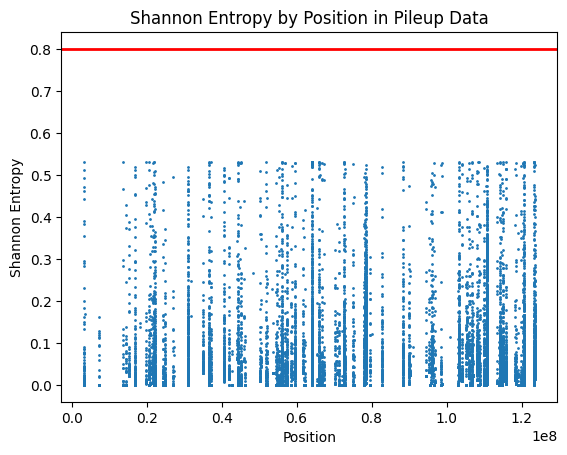

In [ ]:
plt.scatter(pup['pos'], pup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()